# Non-Stationary Contextual Bandits Evaluation

In this notebook we will build a simple setting (contextual bandits) to understand how a non-stationary policy should be evaluated. 

#### Contextual bandits
We introduce a contextual bandit with 2 arms, where the choice of its actions $a_t\in\{0,1\}$ also depends on its context $x_t$, which is sampled from a Context distribution $\mathcal{D}$.
Moreover, at each time $t$ the policy parameter will be given by a time-dependent hyperpolicy $\nu$ that is tuned with the hyperparameters $\rho$.

#### Problem definition 
The environment will be defined by a sinusoidal non-stat process. In order to handle the non-stationary process, the hyperpolicy needs to be based on a similar sinusoidal process, and its goal should be learning and replicating the non-stationary process (thus $\theta_t \simeq \mu(t)= A\sin(\phi t + \psi)$) in order to maximize the rewards. We can choose two different problems:

 - **Non-stationary Context distribution** (for `NS_context=True`): Context will be sampled from a time-dependent context distribution with mean $\mu(t)$ and fixed $\sigma_x$. In this case the bandit has to recognises if $x_t-\mu(t)<0$ (corresponding to $a_t=0$) or if $x_t-\mu(t)>0$ (corresponding to $a_t=1$). The reward is sampled from a Bernoulli distr with param $p_{env} = \text{sigmoid}(x_t-\mu(t))$ if agent chooses $a_t=1$ and with param $1-p_{env}$ if $a_t=0$.

 - **Non-stationary Reward function** (for `NS_context=False`): Context will be sampled from a fixed distribution $\mathcal{N}(0,\sigma_x)$, and the non-stationary process appears in the reward distributions, which will also depend on the sampled contexts. The reward is sampled from a Bernoulli distr with param $p_{env} = \text{sigmoid}(x_t+\mu(t))$ if agent chooses $a_t=1$ and with param $1-p_{env}$ if $a_t=0$. In this case the bandit has to recognise if $x_t+\mu_r(t)\lessgtr0$ (therefore the policies will be slightly different from the previous case, but the hyperpolicy don't change).
 

In the end, the bandit can be represented in two ways, depending on the approach defined by the flag `param_based`:
 - **Action-based exploration**: The stochasticity is given by the policy, which will be represented by a Bernoulli distribution $\pi_{\theta_t}(a_t|x_t) = \left(1-p_a, p_a\right)$, where $p_a \equiv f(\theta_t, x_t) = \text{sigmoid}(x_t\pm\theta_t)$ (depending on `NS_context`) and $\theta_t \sim \nu_\rho(\theta_t|t)$. In this case, the hyperpolicy is deterministic and, at each $t$, the value of $\theta_t$ is given by $\theta_t = \nu_\rho(t) = A_\theta\sin(\phi_\theta t + \psi_\theta)$.
 
 - **Parameter-based exploration**: The stochasticity is given by the hyperpolicy, which is represented by a time-dependent gaussian distribution $\nu_\rho(\theta_t|t) = \mathcal{N}(\mu_\theta(t),\sigma_\theta)$ with $\mu_\theta(t) = A_\theta\sin(\phi_\theta t + \psi_\theta)$ and a constant $\sigma_\theta$. The sampled $\theta_t$ will now define a deterministic policy $\pi_{\theta_t}(x_t)$, which will be represented by a step function centered in $(x_t\pm\theta_t)$ (depending on `NS_context`)

In [12]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Import objects and estimators
from bandit_classes import *
from MIS_estimators import *

## Policy definition

Here we will define the policy class following the structure described at the beginning of the notebook. The action is given by a bool variable. If `stochastic = True`, the policy sample the action from the Bernoulli distribution, otherwise the policy is just a step function.

## Hyperpolicy definition

Here we will define the hyperpolicy class following the structure described at the beginning of the notebook. If `param_based = True`, the hyperpolicy will be stochastic and will sample the $\theta_t$ value from the gaussian distribution with a time dependent mean $\mu_\theta(t)$, otherwise we just have $\theta_t = \mu_\theta(t)$.

# Test environment

Tune the problem changing:
 - `param_based`: Look beginning of the notebook
 - `NS_context`:  Look beginning of the notebook
 - `remove_context`: If True, the context will be always equal to zero. In this case the problem is forced to have a non-stationary reward function.
 - `get_p`: Set to `True` if you want to study the reward process: the `env.play()` method will not return the collected reward at each step, but it will return the bernoulli parameters $p_t$ that define the distributions over the rewards at each step.

In [14]:

#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
##########################


# Get random hyperpolicy
nu  = hyperpolicy(param_based, sigma_theta=1,
                  A=5, phi=0.1, psi=np.pi)



# Initialize environment and the type of problem
env = environment(NS_context, remove_context, sigma_x=2, 
                  A=0.5, phi=0.1, psi=np.pi)

# Play the hyperpolicy
contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=250, get_p=get_p)
contexts_deter, thetas_deter, rewards_deter, actions_deter, NS_process_deter, theta_means_deter = env.play_deter(nu, n_steps=350, get_p=get_p)

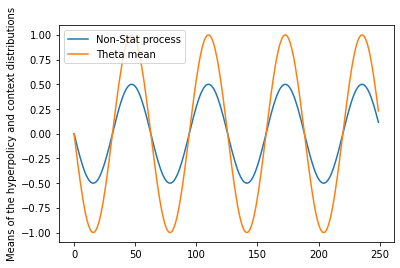

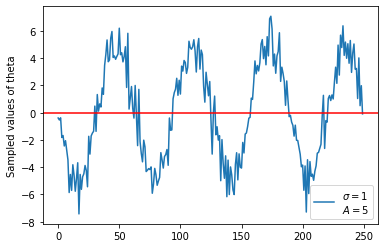

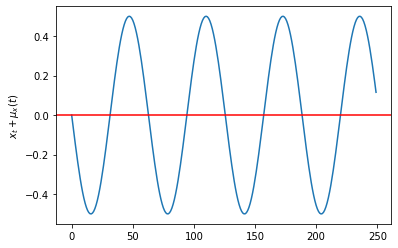

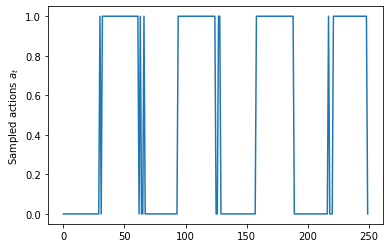

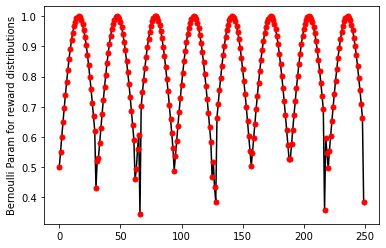

In [15]:
### Plot the evolution of everything

plt.plot(NS_process, label="Non-Stat process")
plt.plot(theta_means/5, label="Theta mean")
plt.ylabel("Means of the hyperpolicy and context distributions")
plt.legend()
plt.show()


plt.plot(thetas, label='$\sigma=1$\n$A=5$')
plt.ylabel("Sampled values of theta")
plt.axhline(y=0, c='r')
plt.legend()
plt.show()


if remove_context or not(NS_context):
    plt.plot(contexts + NS_process)
    plt.ylabel('$x_t + \mu_x(t)$')
else:
    plt.plot(contexts - NS_process)
    plt.ylabel('$x_t - \mu_x(t)$')
plt.axhline(y=0, c='r')
plt.show()


plt.plot(actions)
plt.ylabel('Sampled actions $a_t$')
plt.show()


plt.plot(rewards, c='black')
plt.plot(np.where(rewards>0)[0],  rewards[rewards>0],  'ro', markersize=5)
plt.plot(np.where(rewards==0)[0], rewards[rewards==0], 'bo', markersize=5)
if get_p: 
    plt.ylabel('Bernoulli Param for reward distributions')
else:
    plt.ylabel('Sampled rewards')
plt.show()

### Definition and tests of average rewards

In [16]:
def avg_rew_beta(rewards, beta=1):
    
    # Compute constant normalization term (for beta<1)
    alpha = len(rewards)
    if beta<1:
        beta_normalization = np.array([beta**(i) for i in range(alpha)])[::-1]
        beta_normalization *= (1-beta)/(1-beta**(alpha-1))
    else: 
        beta_normalization = 1/alpha
        
    # Compute average reward
    weighted_rewards = beta_normalization * rewards
    return sum(weighted_rewards), weighted_rewards

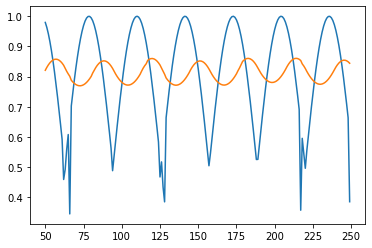

In [18]:
alpha = 50
avg_rew = [avg_rew_beta(rewards[i:i+alpha])[0] for i in range(len(rewards)-alpha)]
plt.plot(np.arange(alpha, len(rewards)), rewards[alpha:])
plt.plot(np.arange(alpha, len(rewards)), avg_rew)
plt.show()


In [35]:
np.sum(np.array([nu.theta_pdf(thetas,5), nu.theta_pdf(thetas,5)]).T, axis=1)

array([1.05614433e-01, 1.40716127e-01, 1.02712016e-01, 6.73587821e-01,
       6.14047094e-01, 7.97167106e-01, 7.51503157e-01, 7.52194245e-01,
       4.52214255e-01, 2.01278302e-03, 8.18456431e-02, 3.42602157e-03,
       2.90926337e-01, 7.29945142e-02, 2.77974477e-03, 4.20917015e-02,
       3.54368173e-01, 2.57231007e-06, 8.23315628e-02, 4.38103805e-03,
       5.66238592e-02, 9.03867686e-02, 2.69219854e-01, 1.46488548e-01,
       7.94903041e-03, 6.38887845e-01, 6.50307854e-01, 6.26123522e-01,
       5.31511968e-01, 4.64960405e-01, 1.24351399e-02, 4.69104498e-01,
       7.50582843e-04, 3.36967059e-02, 7.73302455e-03, 1.50765169e-02,
       1.10186585e-04, 7.01756267e-04, 2.52163362e-08, 1.77697994e-10,
       7.86381895e-14, 5.14319966e-09, 2.23180467e-09, 2.90246114e-14,
       5.36747492e-16, 7.32995633e-10, 3.48081395e-10, 1.66919628e-09,
       4.28836749e-10, 1.25988689e-10, 6.80059736e-17, 1.91476952e-10,
       7.51588257e-11, 5.51162458e-09, 4.47797303e-10, 3.26196317e-12,
      

# MIS Performance Estimator
### *The estimator is built assuming that we are using a parameter-based approach, so it should be used only in this setting. Nevertheless it is possible to try it with action-based to study its properties (no stochastisicy in the choice of theta) -> theta determined deterministically, but the IS weights still consider the hyperpolicy a distribution*

The quantity that we wish to estimate and maximize is the following
$$J=\mathbb{E}_{\nu_\rho(\cdot\vert t+1)} \left[\left. \sum_{i=t+1}^{\infty} \gamma^i R_i \right\vert s_t \right]$$

So, at each timestep, We use the non-stationary policy to estimate the performance of the policy at time $t+1$. We regularize by using importance sampling and, to be specific, we will use MIS-based estimators because the hyperpolicy $\nu_\rho(t)$ changes at each timestep. The "plain" MIS estimator is
$$ \hat{J}=\frac{1}{\alpha}\sum_{i=t-\alpha}^{t}R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} $$

This default version of the estimator is given by having `beta=1`, but different values of beta could be set. In this case the MIS estimator has the following form:
$$ \hat{J} = C_\beta \sum_{i=t-\alpha}^{t} \beta^{t-i} R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)}$$
where $C_\beta=\frac{1-\beta}{1-\beta^{\alpha-1}}$ is the normalization constant.

To test the estimator, `return_type=0` will return the estimated performance, `return_type=1` will return the weigthed rewards, and `return_type=2` will just return the Importance Sampling weights that multipy each reward.

In [36]:
# import MIS estimators
from MIS_estimators import *

## Test Performance Estimator
Study the behaviour of the different terms of the MIS estimator on the last timestep using every collected reward and policy (i.e. with $\alpha=t$)

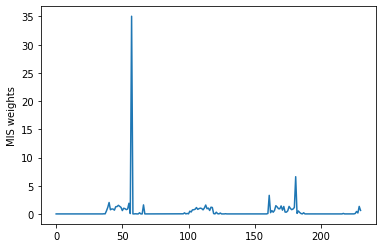

In [37]:
### Study the behaviour of the different terms of the MIS estimator on the last
### timestep using the all the collected rewards and policies (i.e. alpha=t)

# MIS estimator using all the available data
t = len(rewards)-20
MIS_terms = MIS_estimator(nu, thetas[:t+1], rewards[:t+1], t, return_type=1, beta=1)

# Plot the terms to see how they impact the performance estimation
plt.plot(MIS_terms*t)
plt.ylabel("MIS weights")
plt.show()

Now, use the estimator with a smaller value of $\alpha$ to measure the performance of the hyperpolicy at time $t+1$ for each each time $t\in[T-\alpha,T]$ ($T$ is the lenght of the dataset)

100%|██████████| 121/121 [00:10<00:00, 11.11it/s]


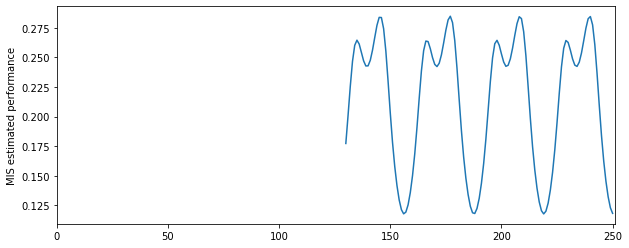

In [362]:
# Prepare array to contain estimated performances
alpha = 130
performances = np.array([])

# Compute performances
for t in tqdm(range(alpha, len(rewards)+1)):
    MIS_performance = MIS_estimator(nu, thetas_deter[t-alpha:t+1], rewards_deter[t-alpha:t+1], t, beta=1)
    performances = np.append(performances, MIS_performance)
    
# Plot the perfromances as function of time
plt.figure(figsize=[10,4])
plt.plot(np.arange(alpha, len(rewards)+1), performances)
plt.ylabel("MIS estimated performance")
plt.xlim(0, len(rewards)+1)
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

After some tests, it is possible to see that different values of $\alpha$ will lead to very different performance estimations over time, even if the collected data is the same. Let's study this behaviour and estimate the future performance with a variable $\alpha$

100%|██████████| 248/248 [00:25<00:00,  9.63it/s]


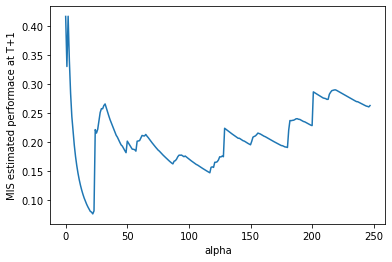

In [363]:
# Prepare array to contain estimated performances
performances = np.array([])
t = len(rewards)

# Compute performances
for alpha in tqdm(range(2,len(rewards))):
    MIS_performance = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t, beta=1)
    performances = np.append(performances, MIS_performance)
    
# Plot the performance at t+1 as function of alpha
plt.plot(performances)
plt.xlabel("alpha")
plt.ylabel("MIS estimated performace at T+1")
plt.show()

It is possible to see that having $\beta<1$ highly reduce the dependency of the performance estimator on $\alpha$, meaning that different value of $\alpha$ will return the same estimated performance given the sampled policies and rewards. This is very important for us, because it allows us to estimate performance in a scenario where the period of the non-stat process is not known.

## Test robustness of estimator with/without $\beta$
We will now see how beta makes the performances estimates more robust wrt the choice of $\alpha$

100%|██████████| 248/248 [00:42<00:00,  5.88it/s]


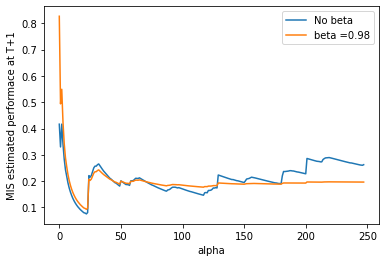

100%|██████████| 111/111 [00:24<00:00,  4.61it/s]


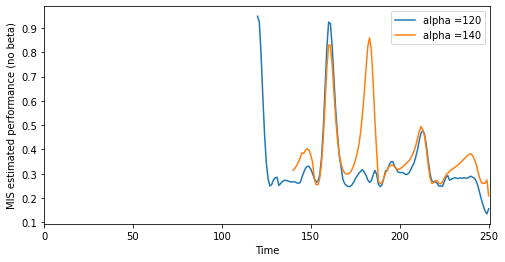

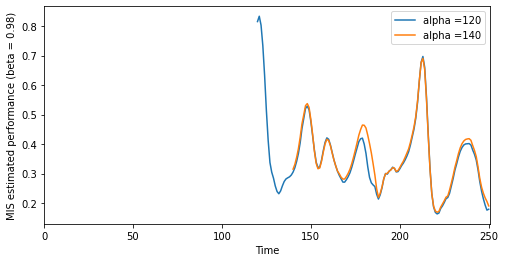

In [364]:
### First compute the performance at time T+1 as
### function of alpha (with and without beta)

beta = 0.98

# Prepare array to contain estimated performances
performances_alpha = np.array([]).reshape(0,2)
t = len(rewards)

# Compute performances as function of alpha
for alpha in tqdm(range(2,len(rewards))):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t)
    beta_performance    = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t, beta=beta)
    performances_alpha  = np.append(performances_alpha, [[no_beta_performance, beta_performance]], axis = 0)

# Plot the performances at t+1 as function of alpha
plt.plot(performances_alpha[:,0], label='No beta')
plt.plot(performances_alpha[:,1], label='beta ='+str(beta))
plt.xlabel("alpha")
plt.ylabel("MIS estimated performace at T+1")
plt.legend()
plt.show()
    
    
    
    
### Now compute performances for each t with 2 different
### values of alpha in the case with beta = 0.98 and no beta

# Prepare array to contain estimated performances
alpha_1 = 120
alpha_2 = 140
performances_1 = np.array([]).reshape(0,2)
performances_2 = np.array([]).reshape(0,2)


# Compute performances with the first value of alpha
for t in tqdm(range(alpha_1, len(rewards)+1)):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha_1:t+1], rewards[t-alpha_1:t+1], t)
    beta_performance = MIS_estimator(nu, thetas[t-alpha_1:t+1], rewards[t-alpha_1:t+1], t, beta=beta)
    performances_1 = np.append(performances_1, [[no_beta_performance, beta_performance]], axis = 0)
    
# Compute performances with the second value of alpha
for t in tqdm(range(alpha_2, len(rewards)+1)):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha_2:t+1], rewards[t-alpha_2:t+1], t)
    beta_performance = MIS_estimator(nu, thetas[t-alpha_2:t+1], rewards[t-alpha_2:t+1], t, beta=beta)
    performances_2 = np.append(performances_2, [[no_beta_performance, beta_performance]], axis = 0)



### Plot results
x_points_1 = np.arange(alpha_1, len(rewards)+1)
x_points_2 = np.arange(alpha_2, len(rewards)+1)
    
# Plot the performances without beta as function of time
plt.figure(figsize=[8,4])
plt.plot(x_points_1, performances_1[:,0], label='alpha ='+str(alpha_1))
plt.plot(x_points_2, performances_2[:,0], label='alpha ='+str(alpha_2))
plt.ylabel("MIS estimated performance (no beta)")
plt.xlabel("Time")
plt.xlim(0, len(rewards)+1)
plt.legend()
plt.show()

# Plot the performances with beta as function of time
plt.figure(figsize=[8,4])
plt.plot(x_points_1, performances_1[:,1], label='alpha ='+str(alpha_1))
plt.plot(x_points_2, performances_2[:,1], label='alpha ='+str(alpha_2))
plt.ylabel("MIS estimated performance (beta = 0.98)")
plt.xlabel("Time")
plt.xlim(0, len(rewards)+1)
plt.legend()
plt.show()

# Study effects of stochasticity

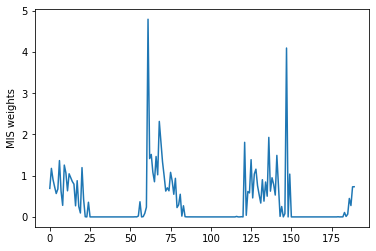

In [9]:
time_of_est = len(thetas)-20

MIS_terms, MIS_est, IS_weights = MIS_estimator_other(nu, thetas[:time_of_est], rewards[:time_of_est], alpha=190, beta=1)

# Plot the terms to see how they impact the performance estimation
plt.plot(IS_weights)
plt.ylabel("MIS weights")
plt.show()

In [23]:
alpha = 130
t_range = range(alpha+1,len(thetas))
MIS_through_time = [MIS_estimator_other(nu, thetas_deter[:i], rewards_deter[:i], alpha=alpha, beta=1)[1] for i in t_range]
wieghts_through_time = [MIS_estimator_other(nu, thetas_deter[:i], rewards_deter[:i], alpha=alpha, beta=1)[2] for i in t_range]

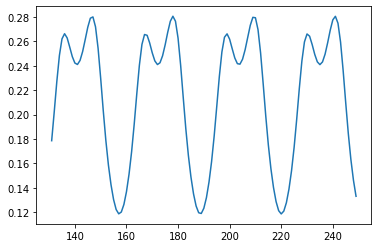

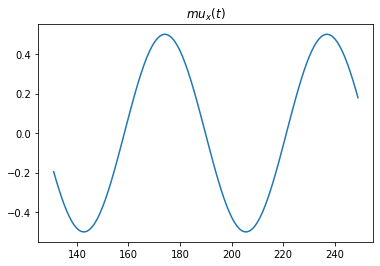

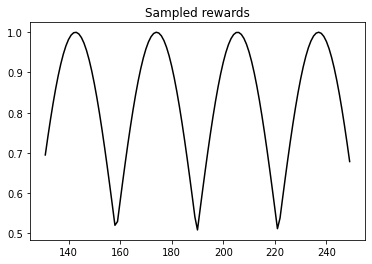

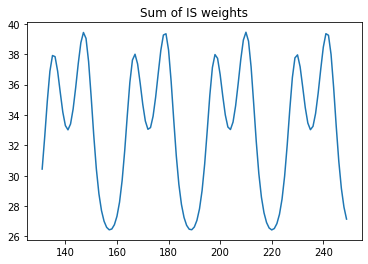

In [17]:
plt.plot(t_range, np.array(MIS_through_time))
plt.show()


plt.plot(t_range, NS_process_deter[t_range])
plt.title('$mu_x(t)$')
plt.show()


plt.plot(t_range, rewards_deter[t_range], c='black')
plt.title('Sampled rewards')
plt.show()


plt.plot(t_range, np.sum(np.array(wieghts_through_time),axis=1))
plt.title('Sum of IS weights')
plt.show()

In [20]:
alpha = 130
t_range = range(alpha+1,len(thetas))
MIS_through_time = [MIS_estimator_other(nu, thetas[:i], rewards[:i], alpha=alpha, beta=1)[1] for i in t_range]
wieghts_through_time = [MIS_estimator_other(nu, thetas[:i], rewards[:i], alpha=alpha, beta=1)[2] for i in t_range]

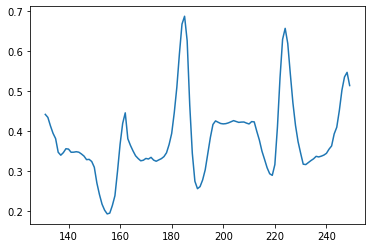

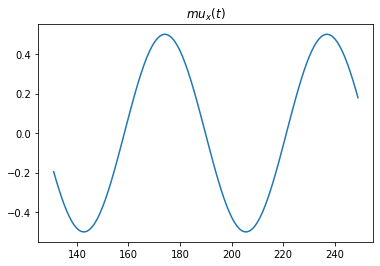

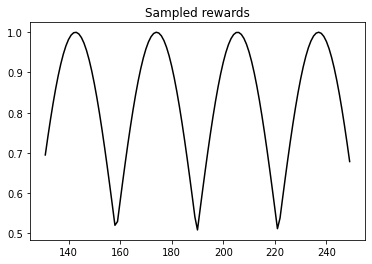

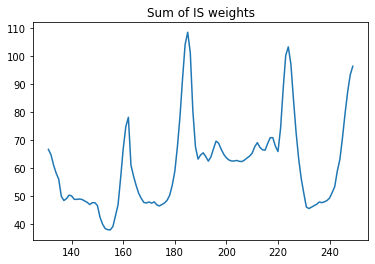

In [21]:
plt.plot(t_range, np.array(MIS_through_time))
plt.show()


plt.plot(t_range, NS_process_deter[t_range])
plt.title('$mu_x(t)$')
plt.show()


plt.plot(t_range, rewards_deter[t_range], c='black')
plt.title('Sampled rewards')
plt.show()


plt.plot(t_range, np.sum(np.array(wieghts_through_time),axis=1))
plt.title('Sum of IS weights')
plt.show()


# Evaluate average performance at T+1 as function of $\sigma_\theta$

In [74]:
#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
##########################

# Parameters
t = 236
alpha = 190
beta = 1
A_values = np.arange(0.25, 4 , 0.25)
#A_sigma_ratio = 2
replicas = 30

performances = np.zeros((len(A_values),replicas))

# Compute performance "replica" times for each value of sigma
for i in range(len(A_values)):
    
    for j in range(replicas):    
        # Create new hyperpolicy and play it 
        nu  = hyperpolicy(param_based, A=A_values[i], phi=0.1, psi=np.pi, sigma_theta=1)
        env = environment(NS_context, remove_context, A=0.5, phi=0.1, psi=np.pi)
        contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
        
        # Evaluate the performance 
        performances[i,j] = MIS_estimator_other(nu, thetas, rewards, alpha, beta)[1]

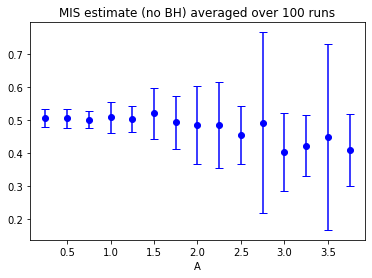

In [78]:
### Plot results
avg_estims = performances.mean(axis=1)
stds = performances.std(axis=1)
plt.errorbar(A_values, avg_estims, yerr=stds, fmt='bo', capsize=4)
plt.xlabel('A')
plt.title('MIS estimate (no BH) averaged over 100 runs')
plt.show()

In [281]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = 200
beta = 1
replicas = 50
all_IS_weights = np.zeros((replicas, alpha))

for i in range(replicas):    
    
    # Create new hyperpolicy and play it 
    nu  = hyperpolicy(param_based, A=6, phi=0.1, psi=np.pi, sigma_theta=2)
    env = environment(NS_context, remove_context, A=0.5, phi=0.1, psi=np.pi)
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)

    # Evaluate the performance 
    all_IS_weights[i] = MIS_estimator_other(nu, thetas, rewards, alpha, beta)[2]

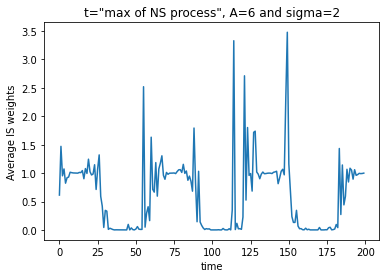

In [282]:
### Plot results
avg_estims = all_IS_weights.mean(axis=0)
plt.plot(avg_estims)
plt.xlabel('time')
plt.ylabel('Average IS weights')
#plt.ylim(-0.3,4.8)
plt.title('t="max of NS process", A=6 and sigma=2')
plt.show()

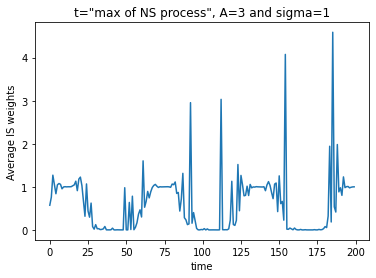

In [22]:
### Plot results
avg_estims = all_IS_weights.mean(axis=0)
plt.plot(avg_estims)
plt.xlabel('time')
plt.ylabel('Average IS weights')
plt.title('t="max of NS process", A=3 and sigma=1')
plt.show()

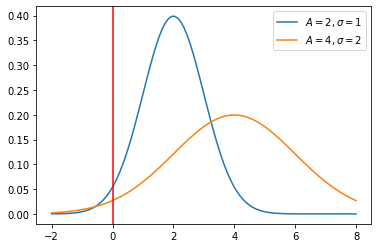

CDF in x=0 of first distr:  0.022750131948179195
CDF in x=0 of second distr: 0.022750131948179195


In [122]:
x = np.linspace(-2,8,100)
plt.plot(x, scipy.stats.norm.pdf(x, loc=2, scale=1), label='$A=2, \sigma=1$')
plt.plot(x, scipy.stats.norm.pdf(x, loc=4, scale=2), label='$A=4, \sigma=2$')
plt.axvline(x=0, c='r')
plt.legend()
plt.show()

print('CDF in x=0 of first distr: ', scipy.stats.norm.cdf(0, loc=2, scale=1))
print('CDF in x=0 of second distr:', scipy.stats.norm.cdf(0, loc=4, scale=2))

# Study MIS with balance heuristics

In [43]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = 230
beta = 1
replicas = 5
all_IS_weights = np.zeros((replicas, alpha))

# Initialize hyperpolicy and env
env = environment(NS_context, remove_context, A=0.5, phi=0.1, psi=np.pi)
nu  = hyperpolicy(param_based, A=5, phi=0.1, psi=np.pi, sigma_theta=1)

for i in tqdm(range(replicas)):    
    
    env.reset()
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
    
    # Evaluate the performance 
    all_IS_weights[i] = MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[0]
    

  0%|          | 0/5 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
### Plot results
avg_estims = all_IS_weights.mean(axis=0)
plt.plot(avg_estims)
plt.xlabel('time')
plt.ylabel('Average IS weights (with BH)')
plt.title('t="max of NS process", A=5 and sigma=3')
plt.show()

In [ ]:
plt.plot(rewards)

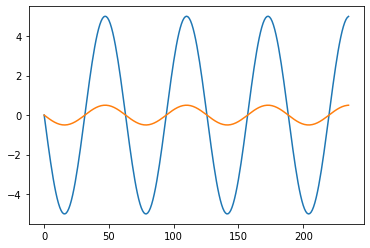

In [44]:
plt.plot(theta_means)
plt.plot(NS_process)

# Check impact of the phase in the estimation

In [130]:
#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
R_inf = 1
alpha = 126
range_phase = np.linspace(0,2*np.pi,20)
n_seeds = 10
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for phase in tqdm(range_phase):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    env = environment(NS_context, remove_context, sigma_x=2, 
                      A=0.5, phi=0.1, psi=phase)
    nu  = hyperpolicy(param_based, sigma_theta=1,
                      A=5, phi=0.1, psi=phase)
    
    for s in range(n_seeds):
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=126, get_p=get_p)
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1] * alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


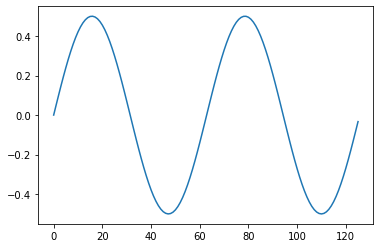

In [131]:
plt.plot(NS_process)

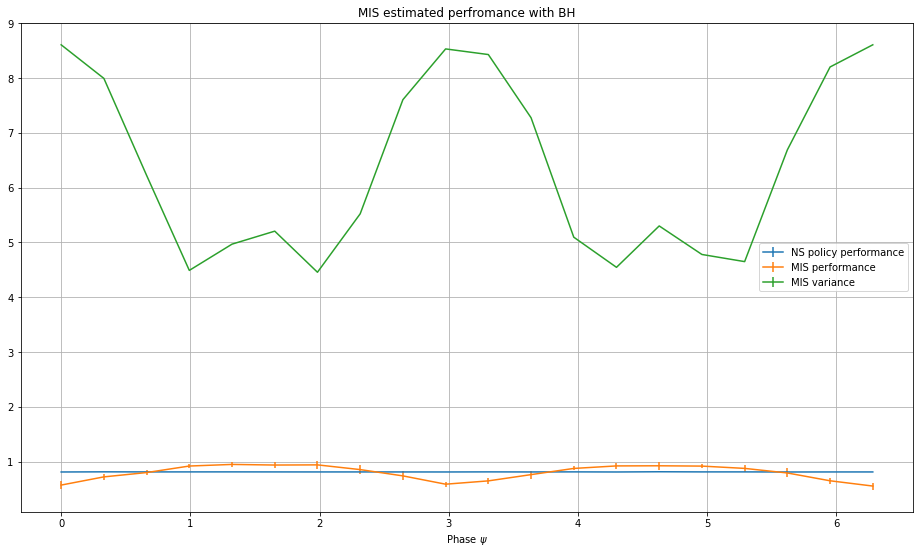

In [132]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_phase, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_phase, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
ax.errorbar(range_phase, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Phase $\psi$')
ax.legend()
plt.title('MIS estimated perfromance with BH')
plt.show()

# Check impact of A in the MIS estimation

In [154]:
#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
R_inf = 1
alpha = 126
range_A = np.linspace(0.5,8,20)
A_sigma_ratio = 2
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for A in tqdm(range_A):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    env = environment(NS_context, remove_context, sigma_x=2, 
                      A=0.5, phi=0.1, psi=np.pi/2)
    sigma = A / A_sigma_ratio
    nu  = hyperpolicy(param_based, sigma_theta=sigma,
                      A=A, phi=0.1, psi=np.pi/2)
    
    for s in range(n_seeds):
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=126, get_p=get_p)
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


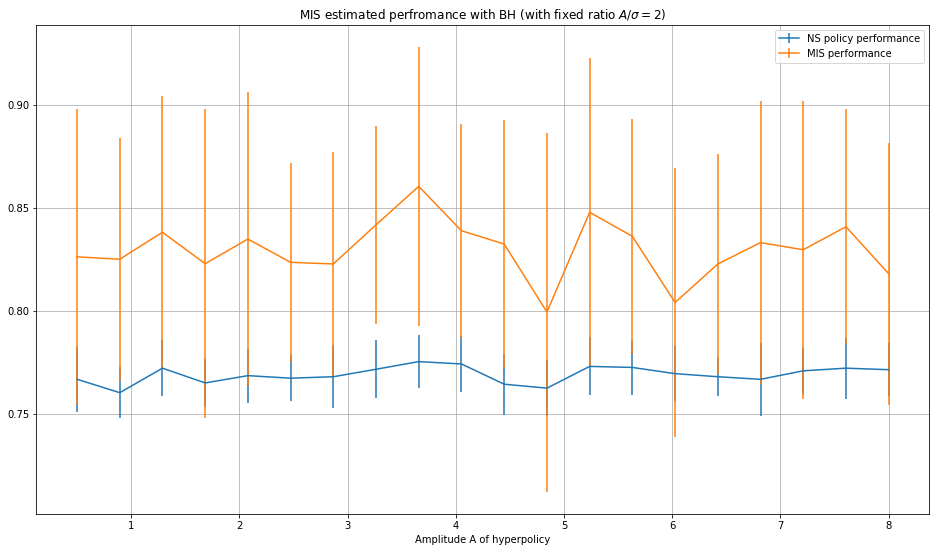

In [155]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_A, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_A, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
ax.errorbar(range_A, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('Amplitude A of hyperpolicy')
ax.legend()
plt.title('MIS estimated perfromance with BH (with fixed ratio $A/\sigma=2$)')
plt.show()

# Check impact of $\sigma_\theta$ in the MIS estimation

In [139]:
#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
R_inf = 1
alpha = 126
range_sigma = np.linspace(0.1,6,30)
A_sigma_ratio = 2 
n_seeds = 20
##########################

perf_NS = []
perf_MIS = []
var_MIS = []

for sigma in tqdm(range_sigma):
    temp_perf_NS = []
    temp_perf_MIS = []
    temp_var_MIS = []
    
    env = environment(NS_context, remove_context, sigma_x=2, 
                      A=0.5, phi=0.1, psi=np.pi/2)
    #sigma = A/A_sigma_ratio
    nu  = hyperpolicy(param_based, sigma_theta=sigma,
                      A=3, phi=0.1, psi=np.pi/2)
    
    for s in range(n_seeds):
        env.reset()
        contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=126, get_p=get_p)
        temp_perf_NS.append(np.mean(rewards[-alpha:]))
        temp_perf_MIS.append(MIS_bh_estimation(nu, thetas, rewards, alpha, beta=1)[1]*alpha)
        temp_var_MIS.append(MIS_bh_variance(nu, thetas, rewards, R_inf, alpha, beta=1))
    perf_NS.append(np.array(temp_perf_NS))
    perf_MIS.append(np.array(temp_perf_MIS))
    var_MIS.append(np.array(temp_var_MIS))
        
perf_NS = np.array(perf_NS)
perf_MIS = np.array(perf_MIS)
var_MIS = np.array(var_MIS)

100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


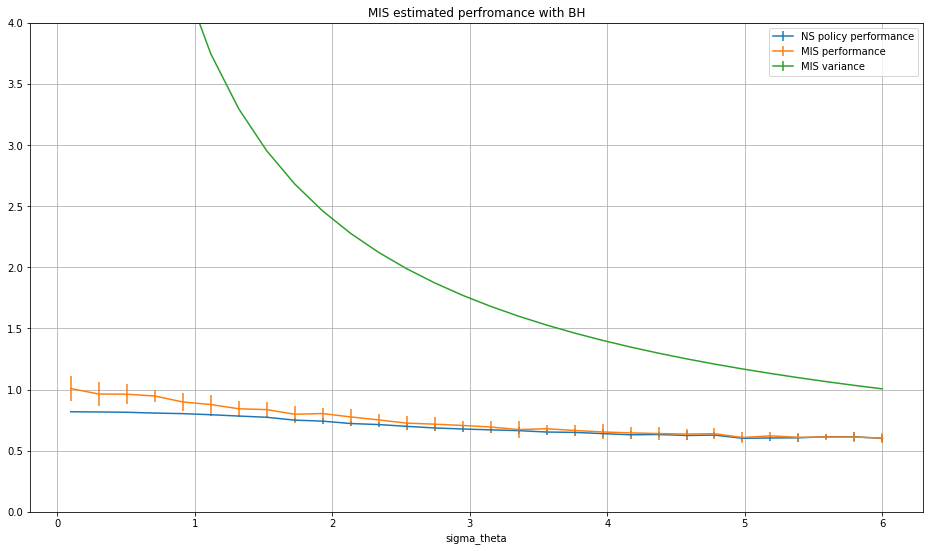

In [140]:
fig, ax = plt.subplots(figsize=(16,9))
ax.errorbar(range_sigma, perf_NS.mean(axis=1), yerr=perf_NS.std(axis=1), label='NS policy performance')
ax.errorbar(range_sigma, perf_MIS.mean(axis=1), yerr=perf_MIS.std(axis=1), label='MIS performance')
ax.errorbar(range_sigma, var_MIS.mean(axis=1), yerr=var_MIS.std(axis=1), label='MIS variance')
ax.grid()
ax.set_xlabel('sigma_theta')
ax.legend()
ax.set_ylim((0,4))
plt.title('MIS estimated perfromance with BH')
plt.show()

# Test MIS estimator as a function of $\nu_\rho(t+1)$ (*Useless*)
After sampling alpha timesteps from the hyperpolicy, see how the hyperpolicy distribution at the next timestep $\nu_\rho(t+1)$ affects the MIS estimation.

In [9]:

class simpler_environment:
    
    def __init__(self, NS_process):
        
        # Store the sinusoidal non-stat process
        self.NS_process = NS_process
        self.T = len(NS_process)
    

    def get_reward(self, action, t, get_p=False):
        
        # Compute current bernoulli parameter
        p_t = (self.NS_process[t] + 1) / 2

        # return the parameter if get_p = true
        if get_p:
            if action:
                return p_t
            else:
                return 1-p_t
        
        # Sample a reward given the chosen action
        if action:
            return scipy.stats.bernoulli.rvs(p_t)
        else:
            return scipy.stats.bernoulli.rvs(1 - p_t)
            
          
        
    def play(self, nu, get_p=False, determ=False):
    
        thetas   = np.array([])
        rewards  = np.array([])
        actions  = np.array([])
        theta_means = np.array([])
    
        # At each timestep...
        for t in range(self.T):
            
            # sample policy 
            if determ:
                policy = policy_class(nu.theta_mean(t), False)
            else:
                policy = nu.sample_policy(t, NS_context=False)

            # choose action (we work without context -> x=0)
            action = policy.action(0)
            
            # Perform a step: change last value of the NS process
            reward = self.get_reward(action, t, get_p)
            
            # Store current values in the arrays
            thetas   = np.append(thetas, policy.theta)
            rewards  = np.append(rewards, reward)
            actions  = np.append(actions, action)
            theta_means   = np.append(theta_means, nu.theta_mean(t))

        return thetas, rewards, actions, theta_means


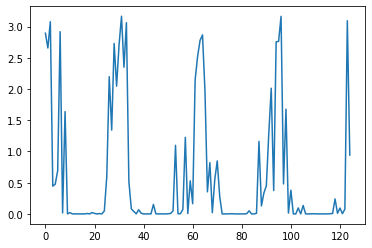

In [184]:
### Build a NS-process with a controllable last value (timestep T+1):
### - we will play until time T and use MIS to estimate performance at 
###   time T+1, in which the distribution of thetas has mean qual to 'last_val'
T = 125
phi = 0.1
psi = 0
A = 5
last_val = 0

NS_process = np.sin( phi * np.arange(T) + psi )
NS_process = np.append(NS_process, last_val)

### Initialize hyperpolicy and env
simple_env = simpler_environment(NS_process[:-1])
nu  = hyperpolicy(param_based=True, sigma_theta=1, theta_means=A*NS_process)

# Run the hyperpolicy 
thetas, rewards, actions, theta_means = simple_env.play(nu, get_p=True)
    
# Evaluate the performance 
IS_weights = MIS_bh_estimation(nu, thetas, rewards, alpha=T, beta=1)[2]
plt.plot(IS_weights)
plt.show()

100%|██████████| 15/15 [00:45<00:00,  3.03s/it]


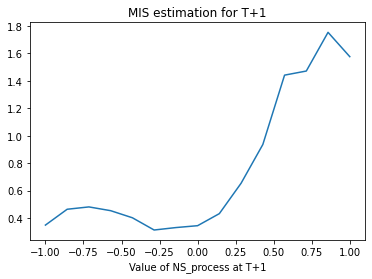

In [196]:
### Repeat process to evaluate performance at T+1 as functions of last value
possible_values = np.linspace(-1, 1, 15)
all_performances = np.zeros(len(possible_values))

# Build NS process up to T and the environment
T = 100
phi = 0.1
psi = 0
A = 5

NS_process = np.sin( phi * np.arange(T) + psi )
simple_env = simpler_environment(NS_process)

# For each possible last value...
for i in tqdm(range(len(possible_values))):
    
    # Complete NS_process and build hyperpolicy
    custom_proc = np.append(NS_process, possible_values[i])
    nu = hyperpolicy(param_based=True, sigma_theta=1, theta_means=A*custom_proc)
    
    # Run hyperpolicy many times to average estimation  
    thetas, rewards, actions, theta_means = simple_env.play(nu, get_p=True)
    all_performances[i] += MIS_bh_estimation(nu, thetas, rewards, alpha=T, beta=1)[1]
      
# Plot estimated performances
plt.plot(possible_values, all_performances)
plt.xlabel('Value of NS_process at T+1')
plt.title('MIS estimation for T+1')
plt.show()